# Kinematics

This notebook provides an environment where to play with the inverse kinematics.

In [79]:
# Define link lengths in mm (link 1 is prismatic)
L2 = 0.120  # Link 2 length
L3 = 0.120  # Link 3 length

x_target = 0.1
y_target = -0.1
z_target = 0.1
yaw_target = 2.0

In [ ]:
import numpy as np
import math

def inverse_kinematics(target):
    """
    Compute the inverse kinematics of the links 2 and 3 of the SCARA arm.
    The first link is prismatic and the inverse kinematics reduces to q1=z.

    Args:
        x (float): The x coordinate of the point we want to reach.
        y (float): The y coordinate of the point we want to reach. 
        z (float): The z coordinate of the point we want to reach.
        yaw (float): The yaw angle of the end effector.
    """

    x, y, z, yaw = target

    distance = math.sqrt(x**2 + y**2)
    
    # Check if the point is reachable
    if distance > (L2 + L3):
        return None, None  # Point is out of reach
    
    q1 = z

    c3 = (x**2 + y**2 - L2**2 - L3**2) / (2 * L2 * L3)
    s3_a = math.sqrt(1 - c3**2)
    s3_b = -s3_a

    q3_a = math.atan2(s3_a, c3)
    q3_b = math.atan2(s3_b, c3)
    
    gamma = math.atan2(y, x)
    q2_a = gamma - math.atan2(L3 * s3_a, L2 + L3 * c3)
    q2_b = gamma - math.atan2(L3 * s3_b, L2 + L3 * c3)
    
    q4_a = yaw - (q2_a + q3_a)
    q4_b = yaw - (q2_b + q3_b)

    return (q1, q2_a, q3_a, q4_a), (q1, q2_b, q3_b, q4_b)


target = (x_target, y_target, z_target, yaw_target)
sol1, sol2 = inverse_kinematics(target)
q1, q2a, q3a, q4a = sol1
q1, q2b, q3b, q4b = sol2

print(f'Solution 1:')
print(f'q1: {np.rad2deg(q1)} ({q1})\nq2: {np.rad2deg(q2a)} ({q2a})\nq3: {np.rad2deg(q3a)} ({q3a})\nq4: {np.rad2deg(q4a)} ({q4a})')

print(f'Solution 2:')
print(f'q1: {np.rad2deg(q1)} ({q1})\nq2: {np.rad2deg(q2b)} ({q2b})\nq3: {np.rad2deg(q3b)} ({q3b})\nq4: {np.rad2deg(q4b)} ({q4b})')

Solution 1:
q1: 5.729577951308233 (0.1)
q2: -98.89579528650383 (-1.7260572441277806)
q3: 107.79159057300762 (1.8813181614606642)
q4: 105.69576373966085 (1.8447390826671164)
Solution 2:
q1: 5.729577951308233 (0.1)
q2: 8.89579528650382 (0.15526091733288394)
q3: -107.79159057300762 (-1.8813181614606642)
q4: 213.48735431266846 (3.72605724412778)


3.72605724412778


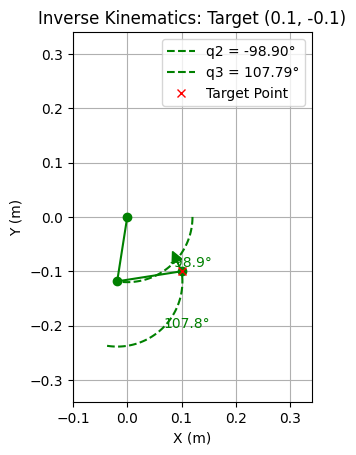

In [ ]:
import matplotlib.pyplot as plt

def plot_configuration(configuration, color=None, draw_arcs=True, draw_target=True, draw_arrow=True, border_size=0.1):
    """
    Visualize the robot's links and the angles computed by the inverse kinematics function.
    Joint 1 is omitted as it is prismatic and its value is not relevant for the plot (q1=z).
    If a list of values is provided for each joint, the method will plot all of them. 
    A configuration should be a tuple of the form (q1, q2, q3, q4).

    Args:
        configuration (tuple[float] | list[tuple[float]]): Joint 4 value.
        draw_arcs (bool): Whether to draw the angle arcs and annotations.
    """

    if isinstance(configuration, tuple) and isinstance(configuration[0], (float, int)):  # Single configuration
        config_list = [configuration]
    elif isinstance(configuration, list) and all(isinstance(c, tuple) and len(c) == 4 for c in configuration):
        config_list = list(configuration)
    elif isinstance(configuration, list) and all(isinstance(c, (float, int)) for c in configuration):
        config_list = configuration
    else:
        raise ValueError("Invalid configuration format. Expected a tuple of 4 values or a list of such tuples.")

    if color is None:
        colors = ['b'] * len(config_list)
    elif isinstance(color, str):
        colors = [color] * len(config_list)
    elif isinstance(color, tuple):
        if len(color) != len(config_list):
            raise ValueError("The number of colors must match the number of configurations.")
        colors = list(color)
    elif isinstance(color, list):
        if len(color) != len(config_list):
            raise ValueError("The number of colors must match the number of configurations.")
        colors = color

    # Plotting the robot arm
    plt.figure()
    
    for config, color in zip(config_list, colors):

        q1, q2, q3, q4 = config

        # Joint positions
        joint2_x = L2 * np.cos(q2)
        joint2_y = L2 * np.sin(q2)
        joint3_x = joint2_x + L3 * np.cos(q2 + q3)
        joint3_y = joint2_y + L3 * np.sin(q2 + q3)
        plt.plot([0, joint2_x, joint3_x], [0, joint2_y, joint3_y], '-o', color=color)

        if draw_arcs:
            # Drawing angle arcs and adding annotations
            arc = np.linspace(0, q2, 100)
            plt.plot(L2 * np.cos(arc), L2 * np.sin(arc), f'{color}--', label=f'q2 = {np.degrees(q2):.2f}°')
            plt.text(L2 * np.cos(q2/2), L2 * np.sin(q2/2), f'{np.degrees(q2):.1f}°', color=color)

            arc = np.linspace(q2, q2 + q3, 100)
            plt.plot(joint2_x + L3 * np.cos(arc), joint2_y + L3 * np.sin(arc), f'{color}--', label=f'q3 = {np.degrees(q3):.2f}°')
            plt.text(joint2_x + L3 * np.cos(q2 + q3/2), joint2_y + L3 * np.sin(q2 + q3/2), f'{np.degrees(q3):.1f}°', color=color)

        if draw_arrow:
            # Draw the end effector orientation
            dx = 0.02 * np.cos(q2 + q3 + q4)
            dy = 0.02 * np.sin(q2 + q3 + q4)
            plt.arrow(joint3_x, joint3_y, dx=dx, dy=dy, head_width=0.02, head_length=0.02, fc=color, ec=color)

    x = L2 * np.cos(q2) + L3 * np.cos(q2 + q3)
    y = L2 * np.sin(q2) + L3 * np.sin(q2 + q3)

    if draw_target:

        # Draw the target point        
        plt.plot(x, y, 'rx', label="Target Point")
    
    # Set axis limits
    x_min = -border_size
    x_max = L2 + L3 + border_size
    y_min = -L2 - L3 - border_size
    y_max = L2 + L3 + border_size
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # Set aspect ratio
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().grid(True)

    plt.title(f"Inverse Kinematics: Target ({round(x, 2)}, {round(y, 2)})")
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.legend()
    plt.show()


plot_configuration([sol1], color=['g'])